In [1]:
import matplotlib.pyplot as plt
import matplotlib
from timezonefinder import TimezoneFinder
import pandas as pd
import numpy as np
import boto3
import math
import geopy.distance
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# # ============= AWS credentials ====================
PROD_AWS_PROFILE = "gsesami-prod"
AWS_REGION = "us-west-2"

prod_session = boto3.session.Session(profile_name=PROD_AWS_PROFILE)

prod_client = prod_session.client(
    "timestream-query", region_name=AWS_REGION)

# 1. Functions


In [2]:
tf = TimezoneFinder()
def findtz_location(latitude, longitude):
    tz_value = tf.timezone_at(lng=longitude, lat=latitude)
    return tz_value

# 1.1 Data Preprocess Functions

In [3]:
#=======================================================================
# = Find consecutive missing data
# = Note that missing data at midnight has been filled up with zero
# = In one day, there might be multiple consective missing data vector
# = In the present instance, we simply set a threshold value
# = If the consective missing number lareger than the threshold value
# = the PV sites will be discarded for further algorithm development.
# =======================================================================
def consecutive_missdata(df):
    # return: [[index_start, nannumb], [index_start, nannumb], ...]
    nagroup_df5min = df.notna().cumsum()[df.isna()]
    lengths_consecutive_na = nagroup_df5min.groupby(nagroup_df5min).agg(len)
    indexlist = lengths_consecutive_na.index.values
    valuelist = lengths_consecutive_na.values
    missdata_dic = []
    for j in range(len(lengths_consecutive_na)):

        # only one continuous missing data
        if j == 0:
            nanindex_start = indexlist[0]
            nannum = valuelist[0]
        else:
            nanindex_start = indexlist[j] + np.sum(valuelist[0:j])
            nannum = valuelist[j]
        missdata_dic.append([nanindex_start, nannum])
    return missdata_dic

In [4]:
#=================================================================
# = Function for processing consective missing data
# ================================================================
def process_consecutive_missdata(df, missdata_list, thred, fillmethod):
    df.set_index('time', inplace=True)
    max_consecutivenan = np.max(np.array(missdata_list)[:, 1])
    # print('max_consecutivenan:', max_consecutivenan)
    if max_consecutivenan > thred:
        return None
    else:
        if fillmethod == 'linear':
            df = df.interpolate().values
        elif fillmethod == 'time':
            df = df.interpolate(method='time').values
        elif fillmethod == 'nearest':
            df = df.interpolate(method='nearest').values
        elif fillmethod == 'ffill': # Replace NaN with preceding values
            df.fillna(method=fillmethod, inplace=True)
        elif fillmethod == 'bfill': # Replace NaN with backward values
            df.fillna(method=fillmethod, inplace=True)
        else:
            RecursionError('Please check the fill method')
        return df

In [5]:
#=================================================================
# = Function for preprocessing missing data: including three steps
# ================================================================
def preprocess_data(df, MIDP, thred, fillmethod, pvsize):
    # Step 1. replace outlier (larger than pvsize) with nan
    df['hour'] = df['time'].dt.hour
    nightlist = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

    df_outlier_idx = df[df[MIDP].astype(float) > 1.1*pvsize]
    df.iloc[df_outlier_idx.index.to_list(), 1] = np.nan

    # Step 2. fill up missing data at midnight with zero  # need to be checked
    df[df['hour'].isin(nightlist)] = df[df['hour'].isin(nightlist)].fillna(0)
    # Step 3. find the consecutive missing data, for example there are half an hour missing data with 5-minute resolution
    # Check if there is missing data
    if df[MIDP].isna().sum() >0:
        # find consecutive missing data
        missdata_list = consecutive_missdata(df[MIDP])
        df = df.drop('hour', axis=1)
        df = process_consecutive_missdata(df=df, missdata_list=missdata_list,thred=thred, fillmethod=fillmethod)
    return df

In [6]:
#=================================================================
# = Preprocess a monitor with steps in details
# ================================================================
def preprocess_single_monitor(MID, df, df_att, thred, fillmethod):
    if MID in df.columns.to_list():
        pvsize = df_att.loc[df_att['source']==MID, 'pvSizeWatt'].values[0]
        df_pv = preprocess_data(df=df[['time', MID]], MIDP=MID, thred=thred, fillmethod=fillmethod, pvsize=pvsize)
        if df_pv is None:
            df.drop(MID, axis=1, inplace=True)
        else:
            df_pv = np.maximum(df_pv, 0)
            df[MID] = df_pv
    else:
        print('there is no such PV systems:', MID)

    return df

## 1.2 Functions for Performance to Peer (P2P) Algorithm

In [7]:
def calculate_energy_output(pv_output, peak_power, Delta_t):
    energy = np.sum(pv_output)*Delta_t
    peak_energy = peak_power*len(pv_output)*Delta_t
    if peak_energy ==0:
        cuf = 0
    else:
        cuf = energy/peak_energy
    return cuf

In [8]:
##================================================================================
## Calculate the wight factors of different peers
##================================================================================
def weight_peers(df_preprocess, df_maxdistance, df_att, peak_power_select, focus_pvid, k, a, time_index, median_zero_remove):
    # df_att: includes attributes of the pv systems
    # df_preprocess: is the AC output of the PV systems with 15-minute resolution
    # focus_pvid: the id of the focused PV system
    # k: is a constant scale factor, which depends on the distribution. For a Gaussian distribution, the value of k is 1.4826
    # a: the exponent parameter for the relationship between MAD and weight factor w, a is generally 4
    # time_index: 

    pv_maxdis_list = df_maxdistance['source'].values
    # 1. capacity utilization factor (cuf)
    print(df_att.loc[df_att['source']==focus_pvid, 'pvSizeWatt'].values)
    if peak_power_select == 'pvsize':
        fP = df_att.loc[df_att['source']==focus_pvid, 'pvSizeWatt'].values[0]
        # some pv site might have no PV size
        if fP == 0:
            print('This PV site has no PV size')
            fP = 50000
    else:
        fP = max(df_preprocess[focus_pvid].values)
    fcuf = df_preprocess[focus_pvid].values/(fP)
    ## 2. find peer list
    # some coluumns, such as time and index, should be removed from the list

    cuftotal_list = []
    curtotal_list = []
    mad_list =[]
    wf_list = []
    df_weight = pd.DataFrame(np.arange(len(pv_maxdis_list)), columns = ['source'])
    df_weight['source'] = pv_maxdis_list
    df_cuf = pd.DataFrame(index=np.arange(len(time_index)))
    df_cuf['time'] = time_index
    df_cuf['Focus PV'] = fcuf
    df_cur = pd.DataFrame(index=np.arange(len(time_index)))
    df_cur['time'] = time_index
    for i, peerid in enumerate(pv_maxdis_list):
        # 3. capacity utilization ratio (CUR)
        if np.all(df_preprocess[peerid].values == 0):
            df_weight = df_weight[df_weight['source'] != peerid]
        else: # the peer should has recorded data
            if peak_power_select == 'pvsize':
                pP = df_att.loc[df_att['source']==peerid, 'pvSizeWatt'].values[0]
            # some pv site might have no PV size
            if pP == 0:
                print('This PV site has no PV size')
                pP = 50000
            else:
                pP = max(df_preprocess[peerid].values)
            pcuf = df_preprocess[peerid].values/pP
            cur = np.array([fcuf[i]/pcuf[i] if pcuf[i] !=0 else 0 for i in range(len(fcuf))])
            # ================== Please check if the zero values should be removed for median /mad calculations
            if median_zero_remove is True:
                cur_for_mad = cur[cur != 0]
                if len(cur_for_mad) == 0: # if cur is all zero values
                    cur_for_mad = [0]
            else:
                cur_for_mad = cur
            # 4. calculate Median Absolute Deviation (MAD)
            mad = stats.median_abs_deviation(cur_for_mad)
            # print('mad:', mad)

            # 5. calcuate the standard deviation. For a gaussian distribution, the value of k is 1.4826, estimated 1.5
            stand_dev = k*mad
            
            # add to the list
            cuftotal_list.append(np.sum(pcuf))
            curtotal_list.append(np.sum(cur))
            mad_list.append(mad)

            # 6. a weight w can be assigned to each peer as a function of the MAD of the CUR focus-peer, a=4 # some consideration
            if mad==0:
                w = 0
            else:
                w = 1/(math.pow(mad,a))
            wf_list.append(w)
            # check if the results are correct
            if i == 0:
                df_check = pd.DataFrame(fcuf, columns = ['fcuf'])
                df_check['peerdata'] = df_preprocess[peerid].values
                df_check['pcuf'] = pcuf
                df_check['cur'] = cur
                df_check['mad'] = [mad]*len(df_check)
                df_check['weight_factor'] = [w]*len(df_check) 
                # df_check.to_csv('df_check.csv', index=None)
            # save cuf for later calculation
            df_cuf[peerid] = pcuf
            df_cur[peerid] = cur

    # save metrics for each peer
    normw = [wj/sum(wf_list) for wj in wf_list]
    # normw = [wj/(max(wf_list)-min(wf_list)) for wj in wf_list]
    df_weight['sumtime_cuf'] = np.array(cuftotal_list)
    df_weight['sumtime_cur'] = np.array(curtotal_list)
    df_weight['weight'] = np.array(wf_list)
    df_weight['normw'] = np.array(normw)
    df_weight['mad'] = np.array(mad_list)
    df_weight['distance(km)'] = df_weight['source'].map(df_maxdistance.set_index('source')['distance(km)'])
    # print('cuf focus:', np.sum(fcuf))
    # print('cuf min:', np.min(cuftotal_list))
    # print('cur min:', np.min(curtotal_list))
    # df_weight['normw'].plot(figsize=(20, 3))
    return df_weight, df_cuf, df_cur


In [9]:
##================================================================================
## find the maximum values in a series according to elements in a list
## maximum value is the normal weight factor, and elements correspording to the peer name
##================================================================================
def find_maxseries_list(elements_list, series):
    # # Create a sample Series and the extended elements list
    # data = {'A': 10, 'B': 20, 'C': 30, 'D': 40, 'E': 50}
    # series = pd.Series(data)

    # elements_list = ['A', 'B', 'C', 'D', 'E', 'F', 'H', 'G', 'I', 'J']
    # Find the element in the extended list corresponding to the maximum value in the Series
    valid_elements_list = [elem for elem in elements_list if elem in series.index]
    if valid_elements_list:
        element_with_max_value = max(valid_elements_list, key=lambda x: series[x])
        # print("Element from the extended list with the maximum value in the Series:", element_with_max_value)
        return element_with_max_value
    else:
        # print("No valid elements found in the extended list.")
        return None

In [10]:
##================================================================================
## Series has even number, find the first index that larger than the percentile 50
##================================================================================
def find_first_larger_index(series):
    # Calculate the 50th percentile
    percentile_50 = series.quantile(0.50)

    # Find the first index that is larger than the 50th percentile
    larger_indices = series[series > percentile_50]
    first_larger_index = larger_indices.index[0] if not larger_indices.empty else None

    return first_larger_index

In [11]:
##================================================================================
## Calculate the reference cuf according to CUF_ref =  percentile_50(CUF, weight)
##================================================================================
def cal_ref(df_cuf, df_distance_cut):
    cuf_ref_list = []
    # Set the "name" column as the index in both DataFrames
    df_normw_factor = df_distance_cut.copy()
    df_normw_factor.set_index('source', inplace=True)
    df_product = df_cuf.copy()
    df_product.iloc[:, 2:] = df_product.iloc[:, 2:].apply(lambda col: col * df_normw_factor['normw'][col.name])
    df_product['hour'] = df_product['time'].dt.hour
    for i in range(len(df_cuf)):
        cuf_weight_peers = df_product.iloc[i, 2:-1]
        cuf_raw_peers = df_cuf.iloc[i, 2:]
        # remove the peers without generation during daytime (7 am - 20 pm)
        hour_i = df_product['hour'].values[i]
        if (hour_i>=6) | (hour_i<=21):
            # Remove zero values
            series_without_zeros = cuf_raw_peers[cuf_raw_peers != 0]
            if len(series_without_zeros) != 0: # all zeros
                cuf_weight_peers = cuf_weight_peers[cuf_raw_peers.index]
        # Calculate the 50th percentile value
        # print(len(cuf_peers))
        percentile_50_value = cuf_weight_peers.quantile(0.50)
        if len(cuf_weight_peers)%2 == 0: # even number
            if cuf_weight_peers.eq(0).all():
                # Find the index corresponding to the 50th percentile value
                peers_list = cuf_weight_peers[cuf_weight_peers == percentile_50_value].index.tolist()
                index_of_percentile_50  = find_maxseries_list(elements_list=peers_list, series=df_normw_factor['normw'])
            else:
                index_of_percentile_50 = find_first_larger_index(series=cuf_weight_peers)
            # print('even number')
        else:
            # print('odd number')
            # Find the index corresponding to the 50th percentile value
            peers_list = cuf_weight_peers[cuf_weight_peers == percentile_50_value].index.tolist()
            # Find the element in the extended list corresponding to the maximum value in the Series
            index_of_percentile_50  = find_maxseries_list(elements_list=peers_list, series=df_normw_factor['normw'])
        # print(index_of_percentile_50)
        cuf_ref = df_cuf[index_of_percentile_50].iloc[i]
        cuf_ref_list.append(cuf_ref)
    df_cuf['ref_cuf'] = np.array(cuf_ref_list)
    # # df_cuf['ref_cuf'].plot(figsize=(20,4))
    return df_cuf  

In [12]:
##=======================================================================================
## The reliability of the P2P at a moment t is evaluated as the weighted MAD of CUR_NORM
##======================================================================================
def cal_phip2p(df_curnorm, df_weight_factor, median_zero_remove):
    phip2p_list = []
    peers_list = df_weight_factor['source'].values
    df_curnorm_peers = df_curnorm[peers_list]
    for i in range(len(df_curnorm)): # same time slot
        curnorm_peers = df_curnorm_peers[peers_list].iloc[i, :] # different peers
        weighted_curnorm_list = []
        for peer in peers_list:
             weighted_curnorm = curnorm_peers[peer]*df_weight_factor[df_weight_factor['source']==peer]['normw'].values
             weighted_curnorm_list.append(weighted_curnorm[0])
        weighted_curnorm_vector = np.array(weighted_curnorm_list)
        if np.all(weighted_curnorm_vector==0):
            phip2p = 0
        else:
            weighted_curnorm_vector = weighted_curnorm_vector[weighted_curnorm_vector!=0]
            phip2p = stats.median_abs_deviation(weighted_curnorm_vector)
        phip2p_list.append(phip2p)
    df_curnorm['phip2p'] = np.array(phip2p_list)
    return df_curnorm 

In [13]:
##================================================================================
## Calculate the threshold value according to P2P values for fault detection
##================================================================================
def p2p_fault_detection(df_cuf, df_cur, df_weight, z, xi_p2p, median_zero_remove):
    # z: the number of standard deviations by which the value is away from the mean value, z=3
    # xi_p2p: $\xi_{p2p}$ is introduced to provide a tolerance margin to the donfidence interval, xi_p2p =5%
    # # some metrics for fault detection
    df_curnorm = pd.DataFrame(index=np.arange(len(df_cuf)), columns=['time'])
    df_curnorm['time'] = df_cuf['time'].values
    mids_list = [x for x in df_cuf.columns.to_list() if x.startswith('MNTR')]
    # 1. calcualte the CUR_NORM
    for mnr in mids_list:
        cur = df_cur[mnr].values
        if median_zero_remove is True:
            cur_for_norm = cur[cur != 0]
        else:
            cur_for_norm = cur
        cur_norm = cur/(np.median(cur_for_norm))
        df_curnorm[mnr] = cur_norm
    # 2. calculate the Phi_p2p to evaluate the reliability of the P2P at each time slot t
    df_curnorm = cal_phip2p(df_curnorm=df_curnorm, df_weight_factor=df_weight, median_zero_remove=median_zero_remove)
    # 3. calculate the confidence interval around P2P
    p2p_ref = df_cuf['P2P_ref'].values
    if median_zero_remove is True:
        p2p_ref_median = p2p_ref[p2p_ref != 0]
    else:
        p2p_ref_median = p2p_ref
    meidian_p2p = np.median(p2p_ref_median)
    confidence_interval_p2p = (z*df_curnorm['phip2p'].values + xi_p2p)*meidian_p2p
    df_curnorm['ci_p2p'] = confidence_interval_p2p
    # 4. threshold value for the fault detection
    # threshold_p2p = meidian_p2p - confidence_interval_p2p
    df_curnorm['thred'] = np.array([meidian_p2p - confidence_interval_p2p[i] if df_curnorm['phip2p'].values[i]!=0 else 0 for i in range(len(df_curnorm))])
    return df_curnorm

In [14]:
##===========================================================
## calculate the distrance according to the location 
##===========================================================
def cal_geodistance(lat1, long1, df_wf, df_att):
    # lat1 long1 is the latitude/longitude of the focus pv
    # df_wf is the weight factor
    # df_att includes PV's attributes, such as latitude/longitude
    distance_list = []
    coords_1 = (lat1, long1)
    for peerid in df_wf['source'].values:
        # print('peerid:', peerid)
        lat2 = df_att[df_att['source']==peerid]['latitude'].values[0]
        long2 = df_att[df_att['source']==peerid]['longitude'].values[0]
        coords_2 = (lat2, long2)
        # print('coords:', coords_1, coords_2)
        geodis = geopy.distance.geodesic(coords_1, coords_2).km
        distance_list.append(geodis)
    df_wf['distance(km)'] = np.array(distance_list)
    return df_wf

In [15]:
##===========================================================
## calculate the distrance according to the location 
##===========================================================
def find_geodistance(focus_pvid, lat1, long1, df_att, max_distance):
    # lat1 long1 is the latitude/longitude of the focus pv
    # df_wf is the weight factor
    # df_att includes PV's attributes, such as latitude/longitude
    pvlist = df_att['source'].values
    df = pd.DataFrame(index=np.arange(len(pvlist)), columns=['source'])
    df['source'] = pvlist
    distance_list = []
    coords_1 = (lat1, long1)
    for peerid in pvlist:
        lat2 = df_att[df_att['source']==peerid]['latitude'].values[0]
        long2 = df_att[df_att['source']==peerid]['longitude'].values[0]
        coords_2 = (lat2, long2)
        # print('coords:', coords_1, coords_2)
        geodis = geopy.distance.geodesic(coords_1, coords_2).km
        distance_list.append(geodis)
    df['distance(km)'] = np.array(distance_list)
    df = df[df['distance(km)']<=max_distance]
    df.sort_values(by=['distance(km)'], inplace=True)
    focus_index = df[(df.source == focus_pvid)].index
    df.drop(focus_index, inplace=True)
    return df

In [16]:
##==============================================================
## calculate the same distance circle of a location (focus pv)
##==============================================================
def cal_samedistance_point(lat, long, maxdistance):
    R = 6378.1 #Radius of the Earth
    if int(maxdistance//10) == 0:
        step_value = 1
    else:
        step_value = int(maxdistance//10)
    radius_list = np.arange(start=0, stop=int(maxdistance+1), step = step_value, dtype=int)
    print(len(radius_list))
    degree_list = np.arange(0, 720, 3)
    # degree_list = np.arange(-360, 360, 3)
    circles_data = []
    for rid in radius_list:
        for i, degreeid in enumerate(degree_list):
            brng = math.pi*(degreeid/360)
            lat1 = math.radians(lat)
            lon1 = math.radians(long)

            lat2 = math.asin(math.sin(lat1)*math.cos(rid/R) + math.cos(lat1)*math.sin(rid/R)*math.cos(brng))
            lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(rid/R)*math.cos(lat1),
                        math.cos(rid/R)-math.sin(lat1)*math.sin(lat2))

            lat2 = math.degrees(lat2)
            lon2 = math.degrees(lon2)
            if i == 0:
                circle_points = np.array([lat2, lon2])
            else:
                circle_points = np.vstack((circle_points, np.array([lat2, lon2])))
        circles_data.append(circle_points)
    return circles_data, radius_list

## 1.3 Functions and Settings for Plotting

In [17]:
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman']
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.rcParams['savefig.dpi'] = 60

In [18]:
def plotP2P_map(focus_lon, focus_lat, circles_list, radius_list, df_weight_factor):
    fig, ax = plt.subplots(figsize=(8, 6), nrows=1)
    ax.plot(focus_lon, focus_lat, marker='o', color='red')
    for d, circle in enumerate(circles_list):
        ax.plot(circle[:, 1], circle[:, 0],'--', color='darkgrey')
        if d%2==1:
            ax.text(circle[0, 1], circle[0, 0], str(int(radius_list[d])) + '(km)', fontdict=font)
        else:
            if d==len(circles_list)-1:
                ax.text(circle[0, 1], circle[0, 0], str(int(radius_list[d])) + '(km)', fontdict=font)
    # peers with weight factors
    longx = df_weight_factor['longitude'].values
    laty = df_weight_factor['latitude'].values
    weight_factors = df_weight_factor['normw'].values
    # print('first point')
    # print(longx[0], laty[0], weight_factors[0], df_weight_factor['distance(km)'].values[0])
    wmax = max(weight_factors)
    sfactor = int(2000/wmax)
    ax.scatter(longx, laty, s=(weight_factors**2)*sfactor, color='b')
    # circle of same distance
    ax.legend()
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latidude', fontsize=20)

In [19]:
#===========================================================================================
## Plot power profile of the focus pv
##===========================================================================================
def plt_power(df_power, focus_pv, time_start_plot, time_end_plot):
    fig, axes = plt.subplots(nrows=1,figsize=(20, 4))
    df_pltpower = df_power[(df_power['time'] > time_start_plot) & (df_power['time'] <= time_end_plot)]
    axes.plot(df_pltpower['time'].values, df_pltpower[focus_pv].values, '-o', label='time start: {}'.format(time_start_plot))
    axes.legend(fontsize=22)
    axes.set_xlabel('Time', fontsize=22)
    axes.set_ylabel('Power (Watt)', fontsize=22)
    axes.tick_params(axis='both', labelsize=22)
    axes.set_title('Generation of the PV on different days')
    axes.grid(axis='y')
    # plt.xticks(rotation=90)
    fig.tight_layout()

In [20]:
##===========================================================================================
## two y axises, one is power and another one is cuf of the focus/reference PV and it's peers
##===========================================================================================
def pltpower_cuf(df_power, df_cuf, focus_pv, reference_MID, topsite_list):
    ## topsite_list is the list for top peers with higher weight factors
    fig, ax1 = plt.subplots(figsize=(20, 5))
    # ax1.plot(df_power['time'], df_power[focus_pv], '--', color='blue', label='Power Focus PV')
    # ax1.plot(df_power['time'], df_power[topsite_list[0]], '--', color='darkorange', label='Power biggest-weight PV')
    # for j, site_id in enumerate(topsite_list):
    #     if j<=10 and site_id != reference_MID:
    #         ax1.plot(df_power['time'], df_power[site_id], '--', label='Power Peer {}'.format(j))
    ax2 = ax1.twinx()
    ax2.plot(df_cuf['time'], df_cuf['Focus PV'], '-o', color='blue', label='CUF Focus PV')
    ax2.plot(df_cuf['time'], df_cuf[reference_MID], '-o', color='red', label='CUF Reference PV')
    ax2.plot(df_cuf['time'], df_cuf[topsite_list[0]], '-o', color='darkorange', label='CUF biggest-weight PV')
    for j, site_id in enumerate(topsite_list):
        if j<=10 and site_id != reference_MID:
            ax2.plot(df_cuf['time'], df_cuf[site_id], '-o', label='CUF Peer {}'.format(j))
    ax1.legend(loc=2, fontsize=14)
    ax2.legend(loc=1, fontsize=14)
    ax2.grid(axis='y')
    fig.tight_layout()

In [21]:
# plot power
def pltpower(df_power, focus_pv, reference_MID, topsite_list):
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.plot(df_power['time'], df_power[focus_pv], '--', color='blue', label='Power Focus PV')
    ax.plot(df_power['time'], df_power[topsite_list[0]], '--', color='darkorange', label='Power biggest-weight PV')
    for j, site_id in enumerate(topsite_list):
        if j<=5 and site_id != reference_MID:
            ax.plot(df_power['time'], df_power[site_id], '--', label='Power Peer {}'.format(j))
    ax.legend(loc=2, fontsize=14)
    ax.grid(axis='y')
    fig.tight_layout()

In [22]:
# plot cuf
def pltcuf(df, reference_MID, topw_MID):
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.plot(df['time'], df['Focus PV'], '-o', color='blue', label='CUF Focus PV')
    ax.plot(df['time'], df[reference_MID], '-^', color='red', label='CUF Reference PV')
    ax.plot(df['time'], df[topw_MID], '-o', color='darkorange', label='CUF biggest-weight PV')
    ax.legend(loc=2, fontsize=14)
    ax.grid(axis='y')
    fig.tight_layout()

In [23]:
# plot Performance to peer results, the closer P2P to 1, the more they are similiar
def plot_constuctP2P_cuf(df, topsite_list, reference_MID):
    fig, ax1 = plt.subplots(figsize=(20, 3))
    # Plot P2P results
    # ax.plot(df['P2P'], '-o', color='black', label='P2P')
    ln1 = ax1.plot(df['time'], df['P2P'], '-o', color='black', label='P2P', lw=2)
    ax2 = ax1.twinx()
    ln2 = ax2.plot(df['time'], df['Focus PV'], '-o', color='blue', label='CUF focus')
    ln3 = ax2.plot(df['time'],df[reference_MID], '-o', color='red', label='CUF Reference')
    lns = ln1 + ln2 + ln3
    for j, site_id in enumerate(topsite_list):
        if j<=5 and site_id != reference_MID:
            lnj = ax2.plot(df['time'],df[site_id], '--', label='CUF peer {}'.format(j))
            lns = lns + lnj
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=2, fontsize=14)
    ax1.grid(axis='y')
    fig.tight_layout()
    
    # fig.savefig('solarperia_20211.pdf')

In [24]:
def plot_constuctP2P(df):
    fig, ax1 = plt.subplots(figsize=(20, 3))
    # Plot P2P results
    # ax.plot(df['P2P'], '-o', color='black', label='P2P')
    ax1.plot(df['time'], df['P2P_ref'], '-o', color='black', label='P2P Reference PV', lw=1.5)
    ax1.plot(df['time'], df['P2P_topw'], '-^', color='red', label='P2P Biggest-Weight PV', lw=1.5)
    ax1.set_ylabel('P2P Values', fontsize=22)
    ax1.legend(loc=2, fontsize=14)
    ax1.grid(axis='y')
    fig.tight_layout()

In [25]:
def plot_daily_p2phist(df, start_time, thred1, thred2):
    # para: P2P_ref or P2P_topw
    fig, axe = plt.subplots(ncols=2, figsize=(16, 3))
    for j, para in enumerate(['P2P_ref', 'P2P_topw']):
        print('parameter:', para)
        para_value = df[para].values
        para_value = para_value[para_value != 0]
        N, bins, patches = axe[j].hist(para_value, edgecolor='white', linewidth=1)
        print('frequncy number', N)
        print('values:', bins)
        indice1 = len([i for i, v in enumerate(bins <= thred1) if v])
        indice2 = len([i for i, v in enumerate(bins <= thred2) if v])
        for i in range(0, indice1):
            patches[i].set_facecolor('darkred')
        for i in range(indice1, indice2):    
            patches[i].set_facecolor('blue')
        for i in range(indice2, len(patches)):
            patches[i].set_facecolor('darkorange')
        axe[j].set_xlabel('{}: Daily performance to peers ({})'.format(start_time, para), fontsize=14)
        axe[j].set_ylabel('Frequency (%)', fontsize=20)
    fig.tight_layout()

In [26]:
def plt_threshold_p2p(df_cuf, df_curnorm, time_start_plot, time_end_plot, P2P_method):
    df_cuf_plotp2p = df_cuf[(df_cuf['time']>=time_start_plot)&(df_cuf['time']<=time_end_plot)]
    df_curnorm_plot = df_curnorm[(df_curnorm['time']>=time_start_plot) & (df_curnorm['time']<=time_end_plot)]
    # calculate limitation bar of P2P with division method
    palette ={"ok": "black", "underperformance": "red", "overperformance": "violet"}
    fig, axe = plt.subplots(nrows=1, figsize=(20, 5))
    axe.plot(df_cuf_plotp2p['time'].values, df_cuf_plotp2p['Focus PV'].values, '-o', color='blue', label='CUF Focus PV')
    axe.plot(df_cuf_plotp2p['time'].values, df_cuf_plotp2p['ref_cuf'].values, '-o', color='darkorange', label='CUF Reference')
    axe.plot(df_curnorm_plot['time'].values, df_curnorm_plot['thred'].values, '--', color='red', label='Fault Detection Threshold on P2P')
    axe.fill_between(df_curnorm_plot['time'].values, y1=1.2, y2=df_curnorm_plot['thred'].values, color='grey')
    # axe.plot(df_cuf_plotp2p['time'].values, df_cuf_plotp2p['P2P_ref'].values, '-^', color='black', label=' P2P Reference')
    if P2P_method == 'division':
        axe.errorbar(df_cuf_plotp2p['time'].values, df_cuf_plotp2p['P2P_ref'].values, color='black', label=' P2P Reference', 
                     yerr=df_cuf_plotp2p[['P2P_lowererror', 'P2P_uppererror']].values.T)
        ay_upper = np.amax(df_cuf_plotp2p['P2P_upperlimit'].values)
        axe.set_ylim(-0.1, int(ay_upper)+2)
        sns.scatterplot(data = df_cuf_plotp2p, x='time', y='P2P_ref', hue='performancelabel_bar', palette=palette, markers='o', s=160, ax=axe)
    else:
        axe.plot(df_cuf_plotp2p['time'].values, df_cuf_plotp2p['P2P_ref'].values, '-^', color='black', label=' P2P Reference')
        sns.scatterplot(data = df_cuf_plotp2p, x='time', y='P2P_ref', hue='performancelabel', palette=palette, markers='o', s=160, ax=axe)
    # axe.set_ylim(-0.1, 1.8)
    axe.legend(fontsize=16)
    axe.set_xlabel('Time', fontsize=16)
    axe.set_ylabel('CUF/P2P/Threshold', fontsize=20)
    fig.tight_layout()

In [27]:
def plt_threshold_p2p_whole(df_cuf, df_curnorm):
    fig, axe = plt.subplots(nrows=1, figsize=(20, 5))
    df_cuf_plotp2p = df_cuf
    df_curnorm_plot = df_curnorm
    axe.plot(df_cuf_plotp2p['time'].values, df_cuf_plotp2p['Focus PV'].values, '-o', color='blue', label='CUF Focus PV')
    axe.plot(df_cuf_plotp2p['time'].values, df_cuf_plotp2p['ref_cuf'].values, '-o', color='darkorange', label='CUF Reference')
    axe.plot(df_cuf_plotp2p['time'].values, df_cuf_plotp2p['P2P_ref'].values, '-^', color='black', label=' P2P Reference')
    axe.plot(df_curnorm_plot['time'].values, df_curnorm_plot['thred'].values, '--', color='red', label='Faul Detection Threshold on P2P')
    axe.fill_between(df_curnorm_plot['time'].values, y1=1.2, y2=df_curnorm_plot['thred'].values, color='grey')

    axe.legend(fontsize=16)
    axe.set_xlabel('Time', fontsize=16)
    axe.set_ylabel('CUF/P2P/Threshold', fontsize=20)
    axe.set_ylim(-0.1, 2.5)
    fig.tight_layout()

# 2 Parameter Setting

In [28]:
# =============== set focus pv systems and time periods =============
time_start = '2023-05-11'
time_end = '2023-05-18'

window_length = 7 # or 'all'

# =========== parameters for preprocessing missing data ==============
fillmethod = 'nearest' # preprocess missing data
thred15min = 10000 # if setting a very large number, it means the missing data will be filled with the fillmethod without dropping any system

# =========== parameters for P2P algorithm =========================
Peak_Power = 'pvsize'
# Peak_Power = 'maxvalue'

max_distance = 10 # km maximum distance for P2P algorithm
# focus_pv = 'MNTR|ef8a8463-6e53-43f7-829f-924e68ba26b3' # nearby peers 
# focus_pv = 'MNTR|JNGL-I2PF-KMWN-XA64' # small mad
# focus_pv = 'MNTR|5708442' # small mad with close peer
# focus_pv = 'MNTR|D36U-90M0-XIHL-0QFU' # more peers
focus_pv = 'MNTR|1155526_1_1_1'
# focus_pv = 'MNTR|1153572_1_1_1'
# focus_pv = 'MNTR|YD4V-2XCP-SRJF-Q71W'
time_start_plot = '2023-05-16 05:00:00'
time_end_plot = '2023-05-16 21:00:00'
# the method to calculate p2p: division means: P2P = CUF_focus/CUF_ref, delta means: P2P = 1- (CUF_ref - CUF_focus), P2P = 1 - (CUF_REF - CUF_FOCUS)/CUF_REF
P2P_method = 'delta' # 'division' or 'detla'
# median_zero_remove decides if the zero values at midnight will be removed or not for median operation
median_zero_remove = True # if remove zero values when calculate median


# 3 Fecthing and Cleaning data

## 3.1 find the target monitor list 

In [ ]:
# ================== 1. find the pv system covers the time periods for the algorithm ==================
df_lasttime = pd.read_csv('../preprocessed_data/daily_last_time_20231016.csv', header=0)
# check if the recorded data covers the time period: time_start_short & time_end_short
df_lasttime = df_lasttime[(df_lasttime['time_start']!='None') & (df_lasttime['time_end'] != 'None')]
# filter data available pv systems
df_filter = df_lasttime[(df_lasttime['time_start']<time_start) & (df_lasttime['time_end']>time_end) & (df_lasttime['time_resolution']==5)]
# find the pv list
pvlist = df_filter['source'].values.tolist()
# df_filter

In [ ]:
# ============== 2. combine recorded data list with their attributions, such as latitude/longitude/timezone ==========
# table with timezone
df_SITE = pd.read_csv('../input_data/SITE_nodeType_20230630.csv', header=0) 
# table with latitude & longitude
df_MNTR = pd.read_csv('../input_data/MNTR_ddb_20230630.csv', header=0)
df_MNTR['timezone'] = df_MNTR['siteId'].map(df_SITE.set_index('source')['timezone'])
df_MNTR['latitude'] = [x[1:] for x in df_MNTR['latitude']]
# combine attribute with the recorded pv systems in one table
att_list = ['timezone', 'latitude', 'longitude', 'tilt', 'azimuth', 'loss', 'pvSizeWatt']
for att in att_list: 
    df_filter[att] = df_filter['source'].map(df_MNTR.set_index('source')[att])
    if att != 'timezone':
        df_MNTR[att] = df_MNTR[att].astype(str)
        df_MNTR[att] = df_MNTR[att].str.strip("'")
        df_MNTR[att] = df_MNTR[att].astype(float)
df_filter['latitude'] = [x[1:] for x in df_filter['latitude']]
# df_filter

## 3.2 Read Raw Data

In [31]:
# ===============  read data of different pv systems & identify its time resolution ===============
# df_5min = pd.read_csv('../preprocessed_data/5min_rawdata_20231016.csv')
# df_15min = pd.read_csv('../preprocessed_data/15min_rawdata_20231016.csv')
df_5min = pd.read_csv('../preprocessed_data/5min_rawdata_20230630.csv', index_col=0)
df_15min = pd.read_csv('../preprocessed_data/15min_rawdata_20230630.csv', index_col=0)
df_15min.head()

,time,MNTR|cf146ea2-85e5-493d-bc10-95451b81c306,MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb,MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad,MNTR|1367154,MNTR|7KWG-VNRN-6XNR-G3P8,MNTR|a29e4bbd-2a8c-4c98-97bb-2dfaac3f18a5,MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78,MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842,MNTR|18fa6b52-3a60-4237-8a57-92df002e6a75,...,MNTR|b417b748-23e0-45f1-9176-48bd4969cea6,MNTR|d6d27efa-f2f8-4764-92f3-0127c1cf7950,MNTR|121a1b52-265e-4909-a506-1551c8b42f83,MNTR|56df64f5-2445-4646-81a7-4a6c5f1fd554,MNTR|9ea5fe97-6648-41e9-adee-74a62febb111,MNTR|74d1cb6d-de04-4b1f-92e7-128db62bcb52,MNTR|72396070-bd7d-4a02-992a-c76ad2e2e02e,MNTR|856dfca0-9316-4d1e-a877-b39133bbf528,MNTR|8ffe8b61-4817-46aa-8123-0e6a17d2fbf6,MNTR|ADWM-8A18-N44Q-9JB9
0,2021-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 00:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_5min['time'] = pd.to_datetime(df_5min['time'])
df_15min['time'] = pd.to_datetime(df_15min['time'])
# ===============  Downsample 5min data to 15min data ===============
df_5min.set_index('time', inplace=True)
df_5min_down =  df_5min.resample('15T').mean()
df_5min_down.reset_index(inplace=True)
# ===============  combine data of 15min and the downsampled 5min ===============
df = pd.merge_asof(df_15min, df_5min_down, on='time')
df.head()

,time,MNTR|cf146ea2-85e5-493d-bc10-95451b81c306,MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb,MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad,MNTR|1367154,MNTR|7KWG-VNRN-6XNR-G3P8,MNTR|a29e4bbd-2a8c-4c98-97bb-2dfaac3f18a5,MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78,MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842,MNTR|18fa6b52-3a60-4237-8a57-92df002e6a75,...,MNTR|3172589,MNTR|7721843,MNTR|1162569_1_1_1,MNTR|1206026_1_2_1,MNTR|0001c02a2a1b,MNTR|918952,MNTR|1148485_1_1_1,MNTR|5556047,MNTR|6039646,MNTR|1189660_1_2_1
0,2021-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 00:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
pvlist_before_preprocess =  [x for x in df.columns.to_list() if x.startswith('MNTR')]
print('PV number before preprocessing missing data:', len(pvlist_before_preprocess))
# df.set_index('time').plot(figsize=(24,3))

PV number before preprocessing missing data: 980


## 3.3 Preprocessing Data

In [34]:
# ======================= Process outliers and missing data ==============
df_preprocess = df.copy()
df_preprocess['time'] = pd.to_datetime(df_preprocess['time'])
for i, MID in enumerate(pvlist_before_preprocess):
    df_preprocess = preprocess_single_monitor(MID=MID, df=df_preprocess, df_att=df_MNTR, thred=thred15min, fillmethod=fillmethod)

df_preprocess.fillna(0, inplace=True)

print('PV number after preprocessing missing data:', len(df_preprocess.columns.to_list())-1)
df_preprocess.head()

PV number after preprocessing missing data: 980


,time,MNTR|cf146ea2-85e5-493d-bc10-95451b81c306,MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb,MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad,MNTR|1367154,MNTR|7KWG-VNRN-6XNR-G3P8,MNTR|a29e4bbd-2a8c-4c98-97bb-2dfaac3f18a5,MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78,MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842,MNTR|18fa6b52-3a60-4237-8a57-92df002e6a75,...,MNTR|3172589,MNTR|7721843,MNTR|1162569_1_1_1,MNTR|1206026_1_2_1,MNTR|0001c02a2a1b,MNTR|918952,MNTR|1148485_1_1_1,MNTR|5556047,MNTR|6039646,MNTR|1189660_1_2_1
0,2021-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 00:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 00:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# ======================= remove the monitors with time zone issue ==============
df_check = df_preprocess.copy()
# df_check.reset_index(inplace=True)
df_check['hour'] = df_check['time'].dt.hour
df_check = df_check[(df_check['hour']==4) | (df_check['hour']==23)]
df_check.set_index('time', inplace=True)

remove_col_list = [x for x in df_check.columns.to_list() if not x.startswith('MNTR')]
df_check.drop(remove_col_list, axis=1, inplace=True)
df_check = df_check[df_check>100]
df_check.dropna(how='all', axis='columns', inplace=True)
timezone_issue_list = df_check.columns.to_list()
# print(timezone_issue_list)
print('total pv sites with wrong time zone:', len(timezone_issue_list))

total pv sites with wrong time zone: 203


In [36]:
df_processed = df_preprocess.copy()
df_processed.drop(timezone_issue_list, axis=1, inplace=True)
df_processed.head()

,time,MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb,MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad,MNTR|1367154,MNTR|7KWG-VNRN-6XNR-G3P8,MNTR|a29e4bbd-2a8c-4c98-97bb-2dfaac3f18a5,MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78,MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842,MNTR|f1c33770-3ab6-4beb-9b6d-fb32dd408b15,MNTR|4e4995c9-16a4-40eb-b94c-ca937ecbb63f,...,MNTR|4404514,MNTR|7721843,MNTR|1162569_1_1_1,MNTR|1206026_1_2_1,MNTR|0001c02a2a1b,MNTR|918952,MNTR|1148485_1_1_1,MNTR|5556047,MNTR|6039646,MNTR|1189660_1_2_1
0,2021-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 00:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 00:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='time'>

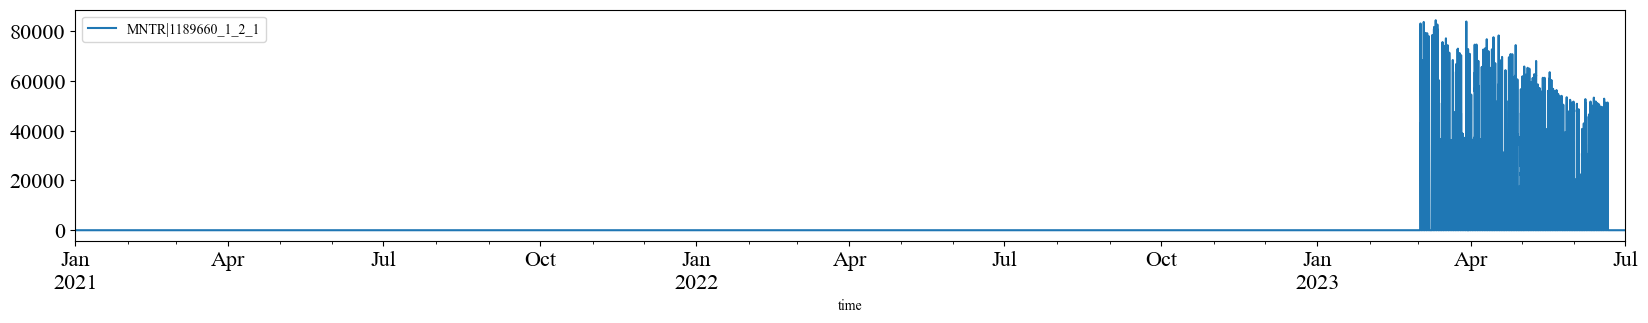

In [37]:
df_processed[['time', MID]].set_index('time').plot(figsize=(20, 3))

In [38]:
# #==============================================================================
# # Find the index of nonzero for a Dataframe: one column
# #==============================================================================

def find_nonzero_indices(df, column_to_check):
    # Find non-zero indices in the specified column
    non_zero_indices = df.index[df[column_to_check] != 0]

    # Check if there are any non-zero values in the column
    if non_zero_indices.any():
        first_nonzero_index = non_zero_indices[0]
        last_nonzero_index = non_zero_indices[-1]
        return first_nonzero_index, last_nonzero_index
    else:
        return None
# all the recorded data are used for P2P calculation
if isinstance(window_length,str): # all
    if MID in df_processed.columns.to_list():
        print('focus pv {} is in the preprocessed data'.format(MID))
        first_last_index = find_nonzero_indices(df=df_processed, column_to_check=MID)
        if first_last_index is None:
            print('There is no nonzero values in {}'.format(MID))
        else:
            first_nonzero_index, last_nonzero_index = first_last_index
            df_for_p2p = df_processed.iloc[first_nonzero_index:last_nonzero_index, :].copy()
            df_for_p2p.index = np.arange(len(df_for_p2p))
    else:
        print('{} is not in the preprocessed data'.format(MID))
# set a time window for P2P calculation
else:
    if MID in df_processed.columns.to_list():
        print('focus pv {} is in the preprocessed data'.format(MID))
        df_for_p2p = df_processed[(df_processed['time']>=time_start) & (df_processed['time']<=time_end)].copy()
        df_for_p2p.index = np.arange(len(df_for_p2p))
    else:
        print('{} is not in the preprocessed data'.format(MID))

df_for_p2p

focus pv MNTR|1189660_1_2_1 is in the preprocessed data


,time,MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb,MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad,MNTR|1367154,MNTR|7KWG-VNRN-6XNR-G3P8,MNTR|a29e4bbd-2a8c-4c98-97bb-2dfaac3f18a5,MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78,MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842,MNTR|f1c33770-3ab6-4beb-9b6d-fb32dd408b15,MNTR|4e4995c9-16a4-40eb-b94c-ca937ecbb63f,...,MNTR|4404514,MNTR|7721843,MNTR|1162569_1_1_1,MNTR|1206026_1_2_1,MNTR|0001c02a2a1b,MNTR|918952,MNTR|1148485_1_1_1,MNTR|5556047,MNTR|6039646,MNTR|1189660_1_2_1
0,2023-05-11 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-05-11 00:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-05-11 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-05-11 00:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-05-11 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,2023-05-17 23:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,2023-05-17 23:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,2023-05-17 23:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
671,2023-05-17 23:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Performance-to-Peer Algorithm

## 4.1. Calculation of weight factors

In [ ]:
# ======================= 4. Performance-to-Peer Algorithm ====================
focus_lat = df_MNTR[df_MNTR['source']==focus_pv]['latitude'].values[0]
focus_lon = df_MNTR[df_MNTR['source']==focus_pv]['longitude'].values[0]

# =================== 4.1. find the peers in specific distance ===========
df_maxdistance_sort = find_geodistance(focus_pvid=focus_pv, lat1=focus_lat, long1=focus_lon, df_att=df_MNTR, max_distance=max_distance)
peer_maxdistance_list = list(set(df_maxdistance_sort['source'].values.tolist()) & set(df_for_p2p.columns.to_list()))
df_maxdistance_sort = df_maxdistance_sort[df_maxdistance_sort['source'].isin(peer_maxdistance_list)]
print('total number of peers in the specific distance:', len(df_maxdistance_sort))

# =================== 4.2. calculate weight factor between the focus PV and its peers ====================
df_weight_factor, df_cuf, df_cur = weight_peers(df_preprocess=df_for_p2p, df_maxdistance=df_maxdistance_sort, df_att=df_MNTR,
                                                peak_power_select=Peak_Power, focus_pvid=focus_pv,  k=1.5, a=4, 
                                                time_index=df_for_p2p['time'], median_zero_remove=median_zero_remove)

df_weight_factor.sort_values(by=['distance(km)'], inplace=True)
df_weight_factor['longitude'] = df_weight_factor['source'].map(df_MNTR.set_index('source')['longitude'])
df_weight_factor['latitude'] = df_weight_factor['source'].map(df_MNTR.set_index('source')['latitude'])
# df_weight_factor


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


11


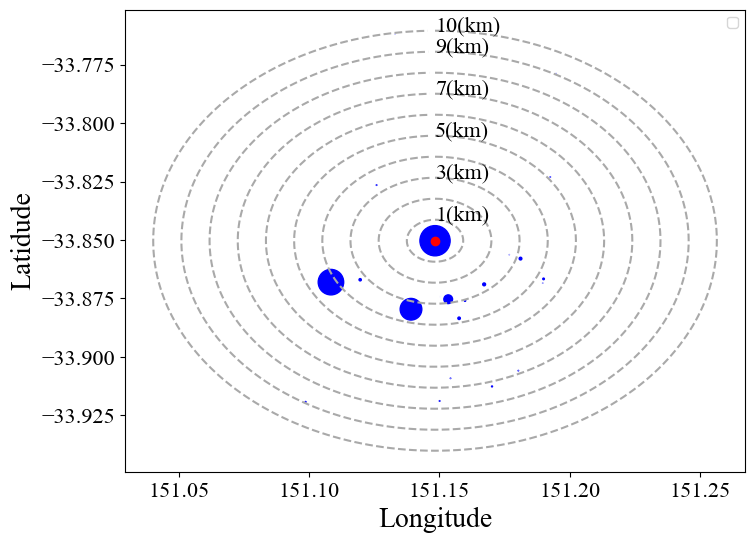

In [40]:
# ============== Plot the PV system and it's peers  ==============
circles_list,radius_list = cal_samedistance_point(lat=focus_lat, long=focus_lon, maxdistance=max_distance)
# plot figure
plotP2P_map(focus_lon=focus_lon, focus_lat=focus_lat, circles_list=circles_list, radius_list=radius_list, df_weight_factor=df_weight_factor)


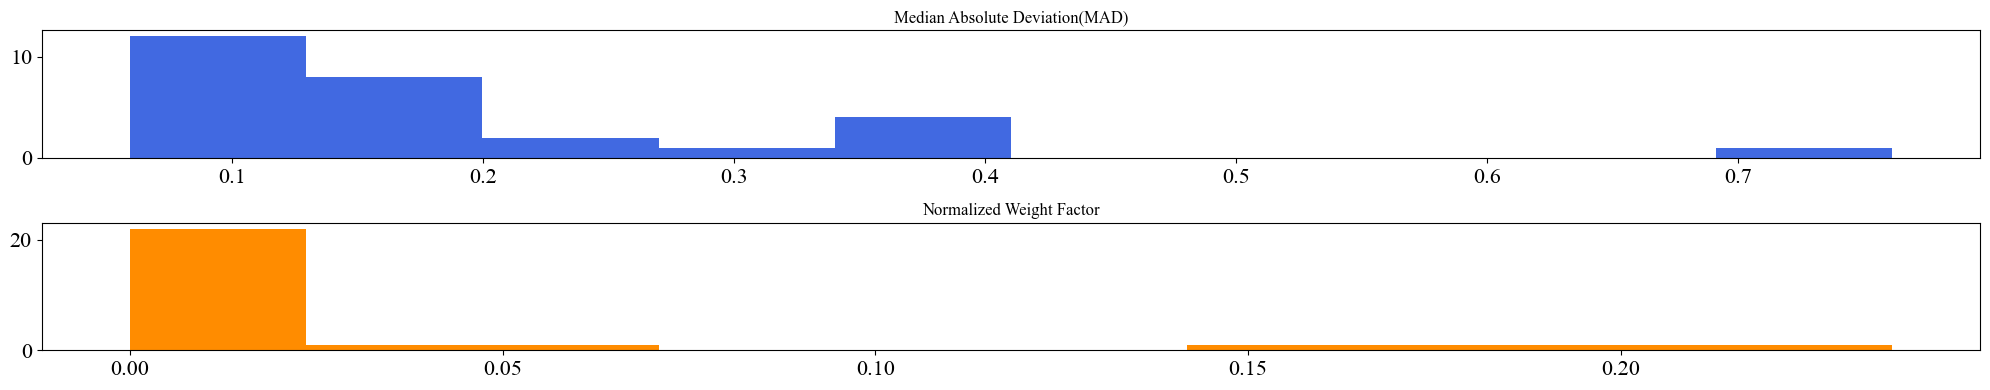

In [41]:
# ================= Plot histogram of the PV system and it's peers  ================
fig, axes = plt.subplots(nrows=2,figsize=(20, 4))
mad = df_weight_factor['mad'].values
normw = df_weight_factor['normw'].values
data_list = [mad, normw]
title_list = ['Median Absolute Deviation(MAD)', 'Normalized Weight Factor']
color_list = ['royalblue', 'darkorange', 'red', 'purple']
for r in range(2):
    data = data_list[r]
    axes[r].hist(data, facecolor=color_list[r])
    axes[r].set_title(title_list[r])

fig.tight_layout()

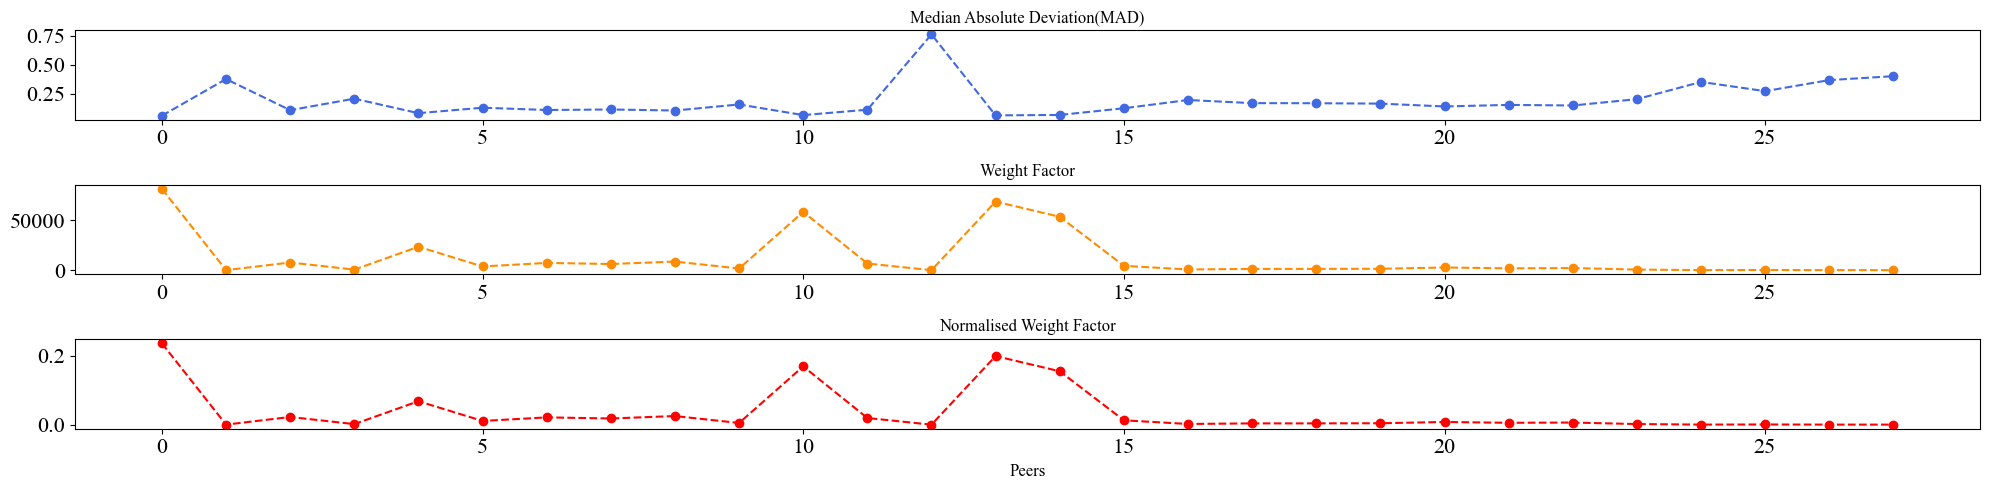

In [42]:
# =============== Plot results of different matrics for the PV system and it's peers  =========================
fig, axes = plt.subplots(nrows=3,figsize=(20, 5))
x = np.arange(len(df_weight_factor))
data_list = [df_weight_factor['mad'].values, df_weight_factor['weight'].values,
             df_weight_factor['normw'].values]
title_list = ['Median Absolute Deviation(MAD)', 'Weight Factor', 'Normalised Weight Factor']
color_list = ['royalblue', 'darkorange', 'red', 'purple', 'black']

for r in range(3):
    data = data_list[r]
    axes[r].plot(x, data_list[r], '--', marker='o', color=color_list[r])
    axes[r].set_title(title_list[r])
    if r ==2:
        axes[r].set_xlabel('Peers', fontsize=12)
fig.tight_layout()

## 4.2. Construction of P2P metric

In [43]:
# # ==================== 8. Constructing the P2P =======================
df_cuf = cal_ref(df_cuf=df_cuf, df_distance_cut=df_weight_factor)

MIDs_list_sortw = df_weight_factor['source'].values
topw_MID = MIDs_list_sortw[0]
reference_cuf = df_cuf['ref_cuf'].values
focus_cuf = df_cuf['Focus PV'].values
if P2P_method == 'division':
    P2P_ref_results = np.array([focus_cuf[c]/(reference_cuf[c]) if reference_cuf[c] !=0 else 0 for c in range(len(focus_cuf))])
    P2P_top_results = np.array([focus_cuf[c]/(df_cuf[topw_MID].values[c]) if df_cuf[topw_MID].values[c] !=0 else 0 for c in range(len(focus_cuf))])
    P2P_upperlimit_results = np.array([focus_cuf[c]/(reference_cuf[c]*0.9) if reference_cuf[c] !=0 else 0 for c in range(len(focus_cuf))])
    P2P_lowerlimit_results = np.array([focus_cuf[c]/(reference_cuf[c]*1.1) if reference_cuf[c] !=0 else 0 for c in range(len(focus_cuf))])
    df_cuf['P2P_upperlimit'] = P2P_upperlimit_results
    df_cuf['P2P_uppererror'] = P2P_upperlimit_results - P2P_ref_results
    df_cuf['P2P_lowerlimit'] = P2P_lowerlimit_results
    df_cuf['P2P_lowererror'] = P2P_ref_results - P2P_lowerlimit_results
else:
    P2P_ref_results = np.array([1-(reference_cuf[c]-focus_cuf[c]) if reference_cuf[c] !=0 else 0 for c in range(len(focus_cuf))])
    P2P_top_results = np.array([1-(df_cuf[topw_MID].values[c] - focus_cuf[c]) if reference_cuf[c] !=0 else 0 for c in range(len(focus_cuf))])
df_cuf['P2P_ref'] = P2P_ref_results
df_cuf['P2P_topw'] = P2P_top_results

df_power_plot = df_processed[(df_processed['time'] > time_start_plot) & (df_processed['time'] <= time_end_plot)]
df_cuf_plot = df_cuf[(df_cuf['time'] > time_start_plot) & (df_cuf['time'] <= time_end_plot)]
df_cuf

,time,Focus PV,MNTR|1153572_1_1_1,MNTR|WAEY-EMEM-5PU2-VDX4,MNTR|2CQC-3H2V-Y6QJ-X041,MNTR|WHX2-R9OL-9NA5-DMC8,MNTR|1149192_1_2_1,MNTR|7UPC-FZ5F-07KP-JEOF,MNTR|1149044_1_1_1,MNTR|330135,...,MNTR|2ZVN-HJT3-R0U9-ZAG8,MNTR|P3KK-7W31-2WYQ-HZIX,MNTR|987654361,MNTR|5556049,MNTR|5556050,MNTR|5556047,MNTR|987654358,ref_cuf,P2P_ref,P2P_topw
0,2023-05-11 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-05-11 00:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-05-11 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-05-11 00:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-05-11 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,2023-05-17 23:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,2023-05-17 23:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,2023-05-17 23:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
671,2023-05-17 23:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


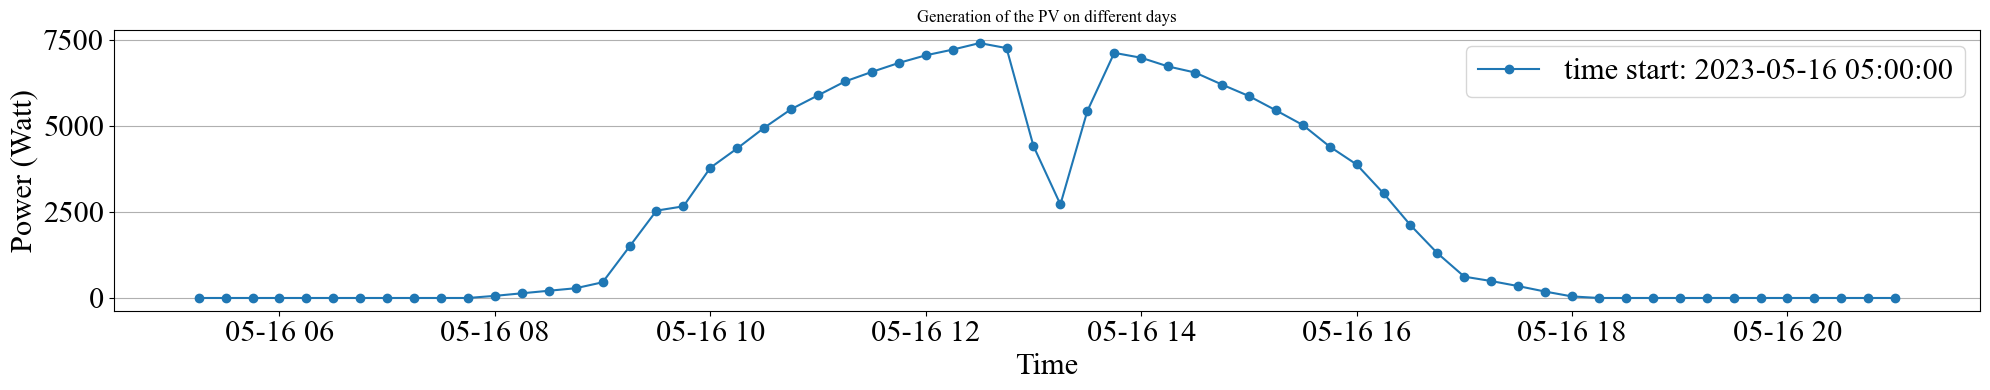

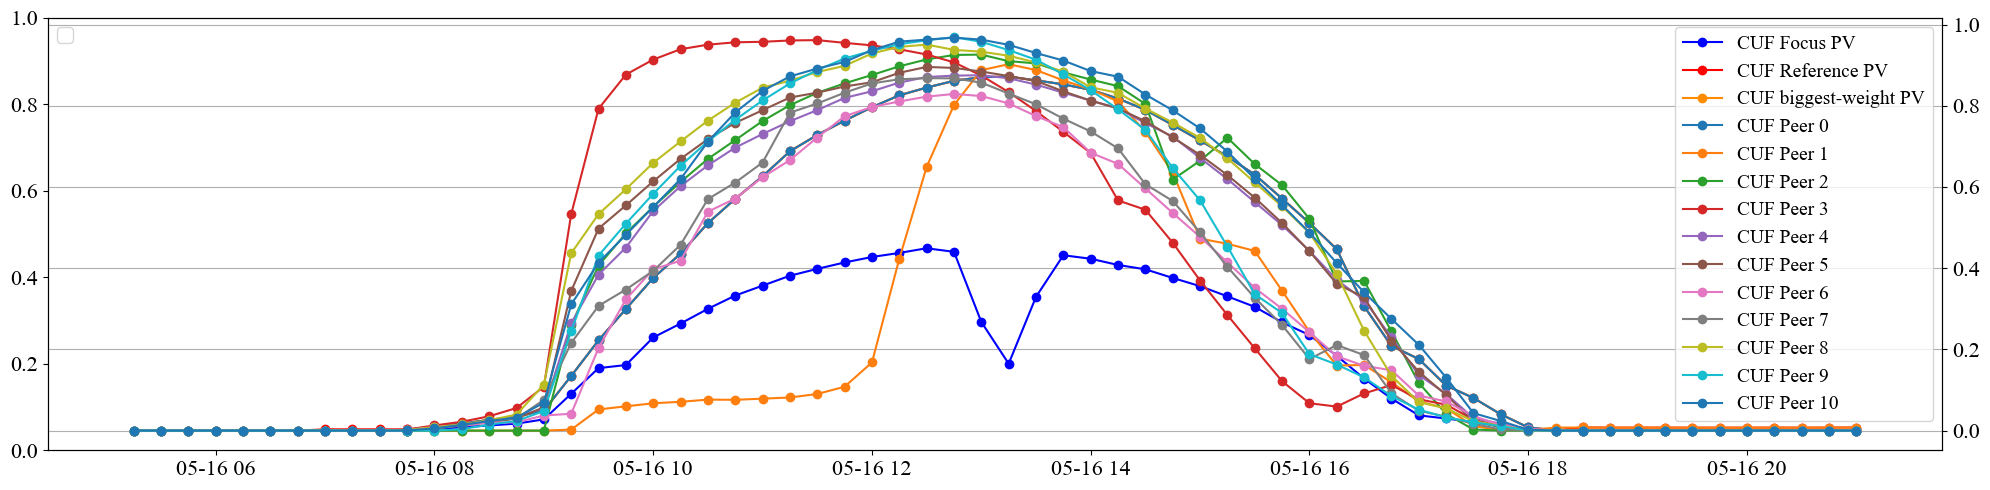

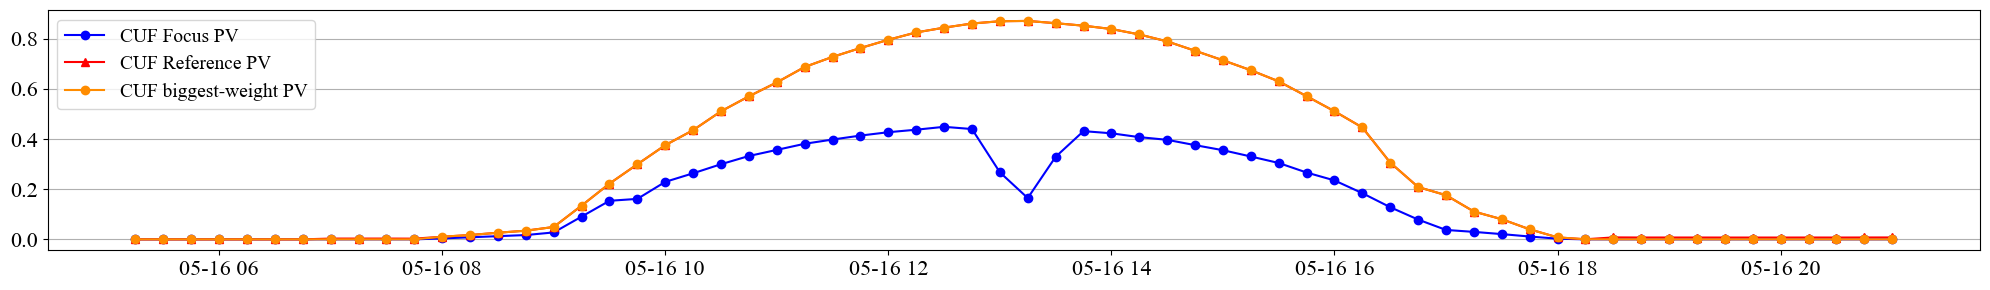

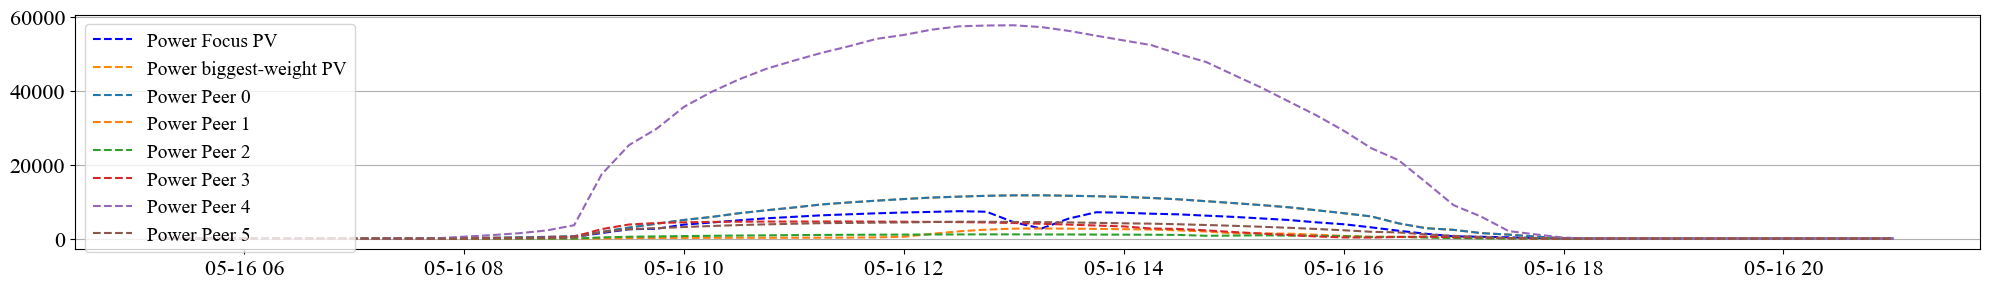

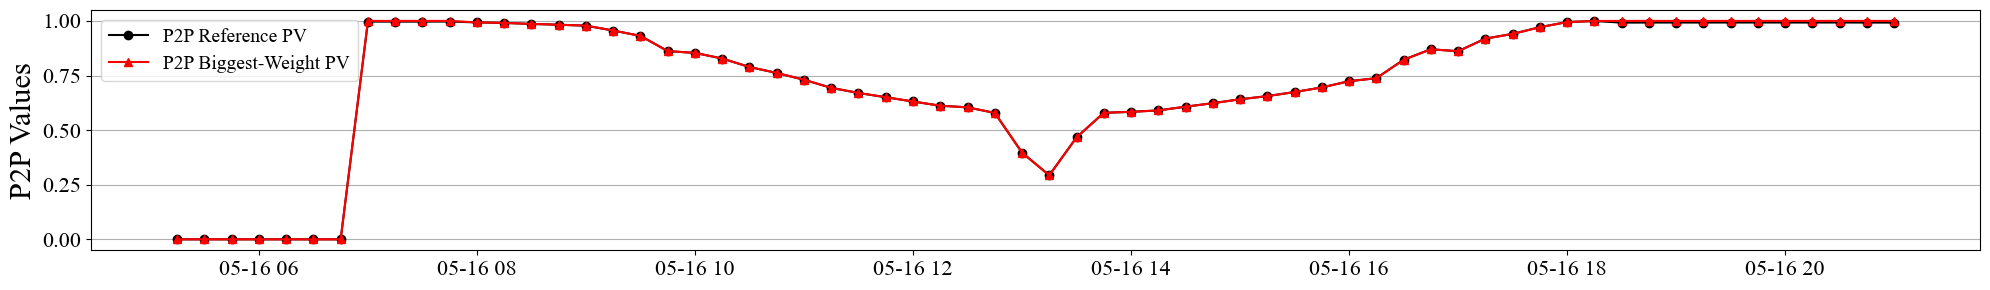

In [44]:
# ==================== plot Power profile of the focus pv ==================
plt_power(df_power=df_power_plot, focus_pv=focus_pv, time_start_plot=time_start_plot, time_end_plot=time_end_plot)
# ==================== plot Power and CUF profiles of the focus and its peers ==================
pltpower_cuf(df_power=df_power_plot, df_cuf=df_cuf_plot, focus_pv=focus_pv, reference_MID='ref_cuf', topsite_list=MIDs_list_sortw)
# ==================== plot cuf of the focus and reference PV ===================
pltcuf(df=df_cuf_plot, reference_MID='ref_cuf', topw_MID=topw_MID)
# ==================== plot powe of the focus and reference PV ==================
pltpower(df_power=df_power_plot, focus_pv=focus_pv, reference_MID='ref_cuf', topsite_list=MIDs_list_sortw)
# ==================== Construction results  ===========================
plot_constuctP2P(df=df_cuf_plot)

## 4.3. P2P for Fault Detection

parameter: P2P_ref
frequncy number [ 1.  1.  1.  0. 10.  6.  4.  4.  4. 26.]
values: [0.29316743 0.36381345 0.43445946 0.50510548 0.5757515  0.64639751
 0.71704353 0.78768955 0.85833556 0.92898158 0.9996276 ]
parameter: P2P_topw
frequncy number [ 1.  1.  1.  0. 10.  6.  4.  4.  4. 26.]
values: [0.29316743 0.36385069 0.43453395 0.5052172  0.57590046 0.64658372
 0.71726697 0.78795023 0.85863349 0.92931674 1.        ]


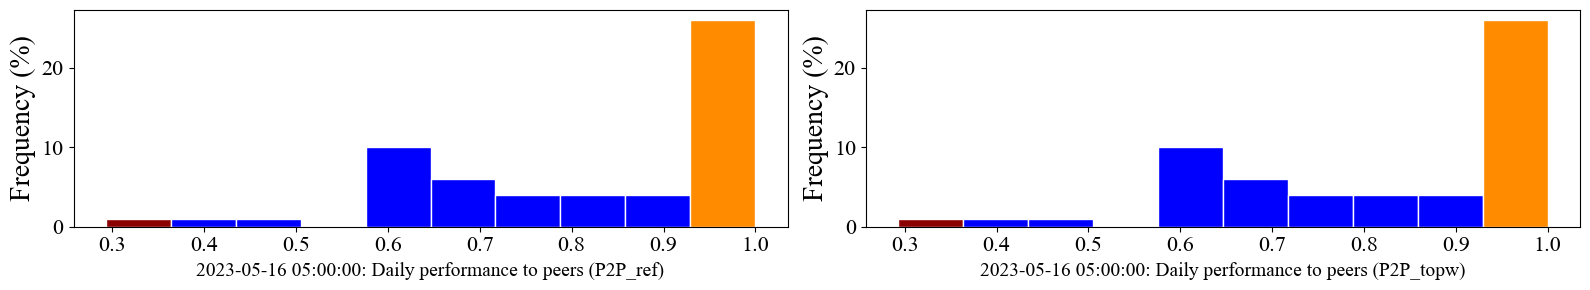

In [45]:
plot_daily_p2phist(df=df_cuf_plot, start_time=time_start_plot, thred1=0.3, thred2=0.9)

In [46]:
# #============== 9. P2P for fault detection ===================
df_curnorm = p2p_fault_detection(df_cuf=df_cuf, df_cur=df_cur, df_weight=df_weight_factor, z=3, xi_p2p=0.05, median_zero_remove=median_zero_remove)
df_curnorm[(df_curnorm['time'] > time_start_plot) & (df_curnorm['time'] <= time_end_plot)].head()

,time,MNTR|1153572_1_1_1,MNTR|WAEY-EMEM-5PU2-VDX4,MNTR|2CQC-3H2V-Y6QJ-X041,MNTR|WHX2-R9OL-9NA5-DMC8,MNTR|1149192_1_2_1,MNTR|7UPC-FZ5F-07KP-JEOF,MNTR|1149044_1_1_1,MNTR|330135,MNTR|PUMS-X5Z2-LZ5B-46VT,...,MNTR|2ZVN-HJT3-R0U9-ZAG8,MNTR|P3KK-7W31-2WYQ-HZIX,MNTR|987654361,MNTR|5556049,MNTR|5556050,MNTR|5556047,MNTR|987654358,phip2p,ci_p2p,thred
501,2023-05-16 05:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045488,0.0
502,2023-05-16 05:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045488,0.0
503,2023-05-16 05:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045488,0.0
504,2023-05-16 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045488,0.0
505,2023-05-16 06:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045488,0.0


In [47]:
df_cuf.loc[(df_cuf['P2P_ref'] >= df_curnorm['thred'])&(df_cuf['P2P_ref'] <= 1.2), 'performancelabel'] = 'ok'
df_cuf.loc[df_cuf['P2P_ref'] < df_curnorm['thred'], 'performancelabel'] = 'underperformance'
df_cuf.loc[df_cuf['P2P_ref'] > 1.2, 'performancelabel'] = 'overperformance'

if P2P_method == 'division':
    upper_limvalue = df_cuf['P2P_upperlimit'].values
    lower_limvalue = np.amax(np.array([df_curnorm['thred'].values, df_cuf['P2P_lowerlimit'].values]), axis=0)
    df_cuf.loc[(df_cuf['P2P_ref'] >= lower_limvalue) &(df_cuf['P2P_ref']<=upper_limvalue), 'performancelabel_bar'] = 'ok'
    df_cuf.loc[(df_cuf['P2P_ref'] < lower_limvalue), 'performancelabel_bar'] = 'underperformance'
    df_cuf.loc[(df_cuf['P2P_ref'] > upper_limvalue), 'performancelabel_bar'] = 'overperformance'

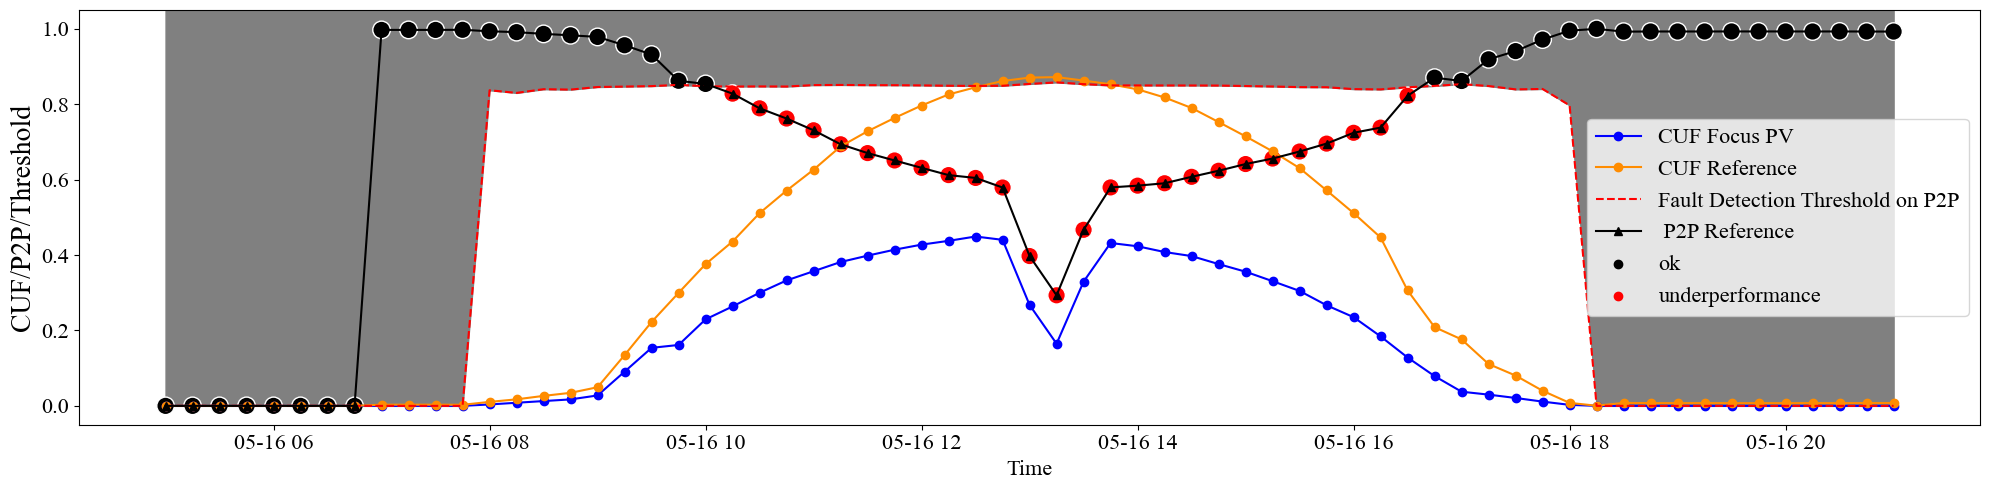

In [48]:
plt_threshold_p2p(df_cuf=df_cuf, df_curnorm=df_curnorm, time_start_plot=time_start_plot, time_end_plot=time_end_plot, P2P_method=P2P_method)